# Analiza eksploracyjna zbioru `used_cars`.

Celem notatnika jest przeprowadzenie analizy eksploracyjnej zbioru used_cars oraz sformułowanie tezy / zadania badawczego prowadzącego do budowy modelu regresji przewidującego `price` (cenę auta) na podstawie cech opisowych.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# ustawienia wyświetlania
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)


In [2]:
# 1) Wczytanie danych
df = pd.read_csv('used_cars.csv')
df.shape, df.columns


((4009, 12),
 Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
        'price'],
       dtype='object'))

## 1. Przegląd danych

Sprawdzamy przykładowe wiersze, typy danych i ogólną strukturę tabeli.


In [3]:
df.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


W zbiorze znajdują się m.in.: marka i model, rok produkcji (`model_year`), przebieg (`milage`), typ paliwa (`fuel_type`), opis silnika (`engine`), skrzynia biegów (`transmission`), kolory, informacja o wypadkowości (`accident`) oraz `clean_title`. Większość z nich ma typ `object` pomimo liczbowej charakterystyki (znaki dolarów, przecinki). Zbiór ten posiada 4009 obserwacji.


## 2. Stopień wypełnienia danych (missingness)

**Stopień wypełnienia danych** opisuje, jaka część obserwacji w danej kolumnie ma realną wartość (a nie brak `NaN`).  
Formalnie można go liczyć np. jako:

- `wypełnienie = 1 - (liczba braków / liczba rekordów)`

To ważne, bo braki danych wpływają na dalsze wnioski i na przygotowanie danych do modelu (np. imputacja lub osobna kategoria `Unknown`).


In [5]:
n = len(df)
missing = pd.DataFrame({
    'missing': df.isna().sum(),
    'missing_%': (df.isna().sum() / n * 100).round(2),
    'filled_%': (100 - (df.isna().sum() / n * 100)).round(2),
})
missing.sort_values('missing_%', ascending=False)


,missing,missing_%,filled_%
clean_title,596,14.87,85.13
fuel_type,170,4.24,95.76
accident,113,2.82,97.18
brand,0,0.00,100.00
milage,0,0.00,100.00
model_year,0,0.00,100.00
model,0,0.00,100.00
engine,0,0.00,100.00
ext_col,0,0.00,100.00
transmission,0,0.00,100.00


W tabeli widać, że zbiór jest ogólnie bardzo dobrze uzupełniony – 9 z 12 kolumn ma 100% wypełnienia (brak wartości NaN). Braki pojawiają się tylko w trzech cechach: clean_title (596 braków, 14.87%), fuel_type (170 braków, 4.24%) oraz accident (113 braków, 2.82%). Oznacza to, że większość analiz i wizualizacji można wykonywać bez problemu, ale przy budowie modelu regresji trzeba świadomie obsłużyć te trzy kolumny (np. przez imputację lub wprowadzenie kategorii „Unknown”), żeby nie tracić dużej liczby rekordów.

## 3. Czyszczenie i konwersja danych numerycznych

W tym zbiorze `milage` i `price` są zapisane jako tekst (np. `51,000 mi.` albo `$10,300`).  
Żeby policzyć statystyki i trenować regresję, trzeba:

- usunąć symbole i separatory tysięcy,
- przekonwertować na typ liczbowy,
- zostawić wartości niepoprawne jako `NaN` (`errors='coerce'`).

Dodatkowo: w niektórych kolumnach pojawia się znak `–` jako „brak informacji” – warto go traktować jak brak.


In [6]:
df_clean = df.copy()

# zamiana '–' na brak informacji (NaN) w kolumnach tekstowych
text_cols = df_clean.select_dtypes(include='object').columns
for c in text_cols:
    df_clean[c] = df_clean[c].replace('–', np.nan)

# konwersje numeryczne
df_clean['milage'] = (
    df_clean['milage'].astype(str)
      .str.replace(' mi.', '', regex=False)
      .str.replace(',', '', regex=False)
      .str.strip()
)
df_clean['milage'] = pd.to_numeric(df_clean['milage'], errors='coerce')

df_clean['price'] = (
    df_clean['price'].astype(str)
      .str.replace('$', '', regex=False)
      .str.replace(',', '', regex=False)
      .str.strip()
)
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')

df_clean['log_price'] = np.log1p(df_clean['price'])

df_clean['model_year'] = pd.to_numeric(df_clean['model_year'], errors='coerce')

df_clean[['model_year', 'milage', 'price']].dtypes, df_clean[['model_year','milage','price']].isna().sum()


(model_year    int64
 milage        int64
 price         int64
 dtype: object,
 model_year    0
 milage        0
 price         0
 dtype: int64)

## 4. Inżynieria cech

Część informacji numerycznych jest „ukryta” w tekście. Przykład: `engine` często zawiera moc (`HP`) i pojemność (`L`).  
Wydobywamy:

- `hp` — moc silnika,
- `displacement_l` — pojemność w litrach.

Z `transmission` wyciągamy cechy pomocnicze:

- `is_automatic` — skrzynia automatyczna (0/1),
- `is_cvt` — CVT (0/1),
- `n_speeds` — liczba biegów, jeśli da się odczytać z tekstu.


In [7]:
engine = df_clean['engine'].fillna('').astype(str).str.strip()

df_clean['hp'] = pd.to_numeric(engine.str.extract(r'(\d+(?:\.\d+)?)\s*HP', expand=False), errors='coerce')
df_clean['displacement_l'] = pd.to_numeric(engine.str.extract(r'(\d+(?:\.\d+)?)\s*L', expand=False), errors='coerce')

trans = df_clean['transmission'].fillna('').astype(str)
df_clean['is_automatic'] = trans.str.contains(r'\bA/T\b|Automatic', case=False, regex=True).astype(int)
df_clean['is_cvt'] = trans.str.contains('CVT', case=False, regex=False).astype(int)
df_clean['n_speeds'] = pd.to_numeric(trans.str.extract(r'(\d+)\s*-\s*Speed', expand=False), errors='coerce')

df_clean.describe()

,model_year,milage,price,log_price,hp,displacement_l,is_automatic,is_cvt,n_speeds
count,4009.000000,4009.000000,4.009000e+03,4009.000000,3201.000000,3792.000000,4009.000000,4009.000000,2154.000000
mean,2015.515590,64717.551010,4.455319e+04,10.302401,332.206498,3.684454,0.785233,0.024944,6.833798
std,6.104816,52296.599459,7.871064e+04,0.850058,122.258492,1.417481,0.410712,0.155974,1.867723
min,1974.000000,100.000000,2.000000e+03,7.601402,70.000000,0.650000,0.000000,0.000000,1.000000
25%,2012.000000,23044.000000,1.720000e+04,9.752723,248.000000,2.500000,1.000000,0.000000,6.000000
50%,2017.000000,52775.000000,3.100000e+04,10.341775,310.000000,3.500000,1.000000,0.000000,7.000000
75%,2020.000000,94100.000000,4.999000e+04,10.819598,400.000000,4.700000,1.000000,0.000000,8.000000
max,2024.000000,405000.000000,2.954083e+06,14.898699,1020.000000,8.400000,1.000000,1.000000,10.000000


Po wydobyciu cech z kolumn engine i transmission widać, że da się z nich uzyskać sensowne zmienne liczbowe, ale z różnym stopniem kompletności. Pojemność silnika (displacement_l) udało się odczytać dla zdecydowanej większości rekordów, więc to jest mocna, „pewna” cecha do dalszych analiz. Moc silnika (hp) też wygląda sensownie, ale brakuje jej w ok. jednej piątej obserwacji, co wynika z tego, że nie wszystkie opisy silnika zawierają ten parametr w jednolitym formacie. Najsłabiej wypada liczba biegów (n_speeds) – udało się ją wyciągnąć tylko dla około połowy aut, bo wiele wpisów w transmission nie ma postaci „x-Speed”, tylko ogólny opis typu „Automatic” albo skrót „A/T”.

Z samych skrzyń biegów widać też wyraźny trend: w zbiorze dominują automaty, bo zmienna is_automatic wskazuje, że około trzy czwarte aut zostało oznaczonych jako automatyczne. CVT pojawia się rzadko, na poziomie kilku procent.

W przypadku ceny i przebiegu rozkłady są mocno zróżnicowane, co jest typowe dla rynku aut używanych, ale szczególnie cena ma ekstremalny przypadek – maksymalna wartość jest bardzo wysoka i wygląda jak obserwacja odstająca (potencjalnie błąd ogłoszenia). To właśnie dlatego log_price jest sensownym dodatkiem: po logarytmowaniu rozkład ceny staje się bardziej „normalny” i stabilny, co zwykle pomaga w regresji i zmniejsza wpływ skrajności.

## 5. Statystyki opisowe: zakres i zmienność

Dla zmiennych numerycznych sprawdzamy: minimum, kwartyle, medianę, maksimum i odchylenie standardowe.  
To pozwala ocenić:

- **zakres** (jak bardzo wartości się rozciągają),
- **zmienność** (czy dane są skupione czy „rozlane”),
- potencjalne **odstające obserwacje** (outliery).


In [8]:
num_cols = ['price', 'milage', 'model_year', 'hp', 'displacement_l', 'n_speeds', 'is_automatic', 'is_cvt']
df_clean[num_cols].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).T


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price,4009.0,44553.190322,78710.635554,2000.00,4000.00,6996.6,9950.0,17200.0,31000.0,49990.0,79999.0,111600.0,272713.28,2954083.0
milage,4009.0,64717.551010,52296.599459,100.00,634.68,3541.2,8648.6,23044.0,52775.0,94100.0,137486.4,165000.0,222428.00,405000.0
model_year,4009.0,2015.515590,6.104816,1974.00,1997.08,2004.0,2007.0,2012.0,2017.0,2020.0,2022.0,2023.0,2023.00,2024.0
hp,3201.0,332.206498,122.258492,70.00,130.00,161.0,185.0,248.0,310.0,400.0,490.0,560.0,707.00,1020.0
displacement_l,3792.0,3.684454,1.417481,0.65,1.50,2.0,2.0,2.5,3.5,4.7,6.0,6.2,6.70,8.4
n_speeds,2154.0,6.833798,1.867723,1.00,1.00,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10.00,10.0
is_automatic,4009.0,0.785233,0.410712,0.00,0.00,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0
is_cvt,4009.0,0.024944,0.155974,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_8720\1643872059.py:6: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  milage_clip = df_clean['milage'].clip(upper=df_clean['milage'].quantile(0.99))


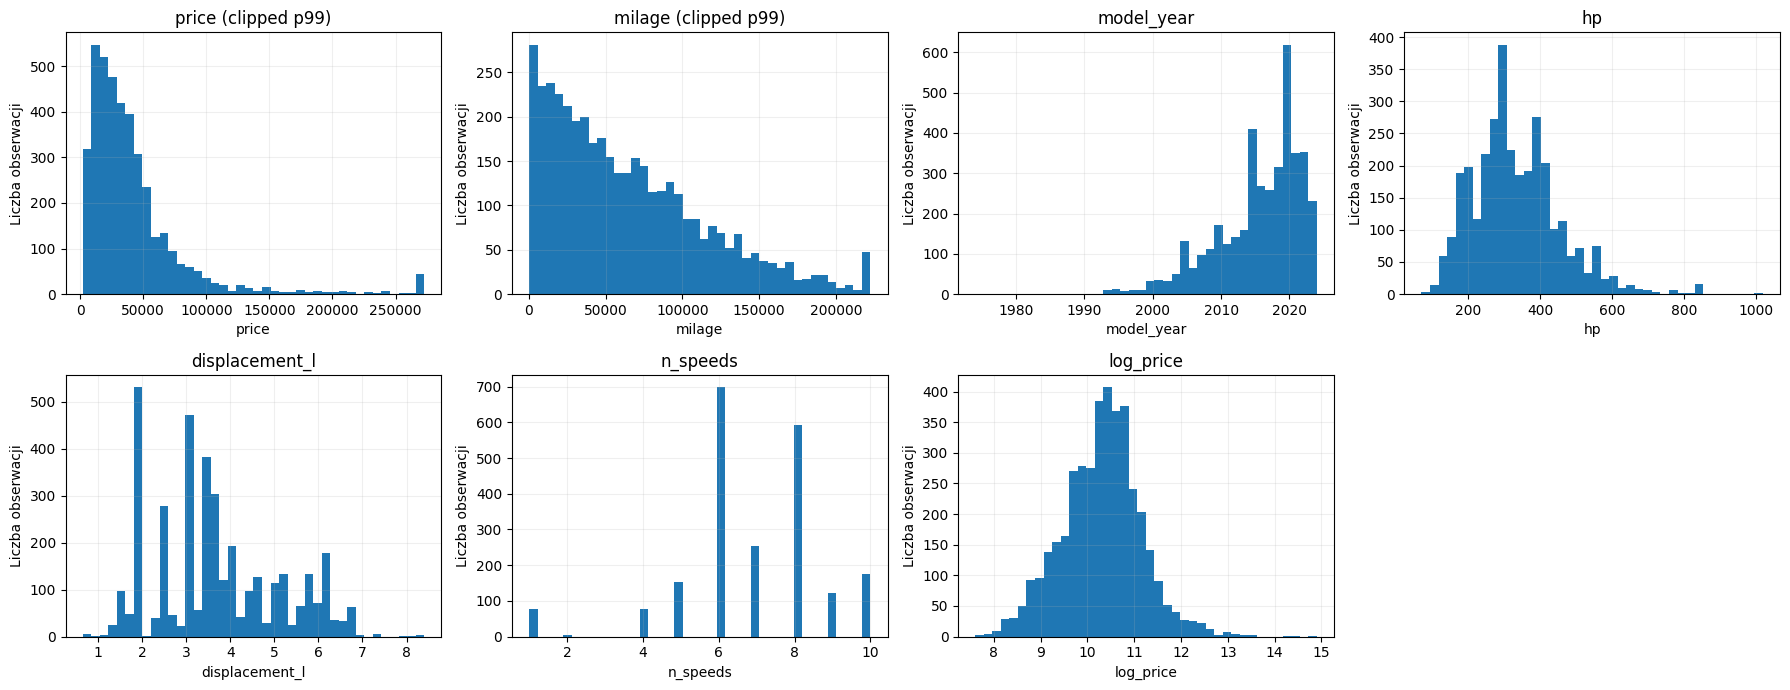

In [9]:
# Histogramy na siatce (price i milage przycięte do 99 percentyla)

cols = ['price', 'milage', 'model_year', 'hp', 'displacement_l', 'n_speeds', 'log_price']

price_clip = df_clean['price'].clip(upper=df_clean['price'].quantile(0.99))
milage_clip = df_clean['milage'].clip(upper=df_clean['milage'].quantile(0.99))

n_plots = len(cols)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 7))
axes = axes.ravel()

for i, col in enumerate(cols):
    ax = axes[i]

    if col == 'price':
        data = price_clip.dropna()
        ax.set_title('price (clipped p99)')
        bins = 40
    elif col == 'milage':
        data = milage_clip.dropna()
        ax.set_title('milage (clipped p99)')
        bins = 40
    else:
        data = df_clean[col].dropna()
        ax.set_title(col)
        bins = 40

    ax.hist(data, bins=bins)
    ax.set_xlabel(col)
    ax.set_ylabel('Liczba obserwacji')
    ax.grid(True, alpha=0.2)

# usuń puste pola siatki
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


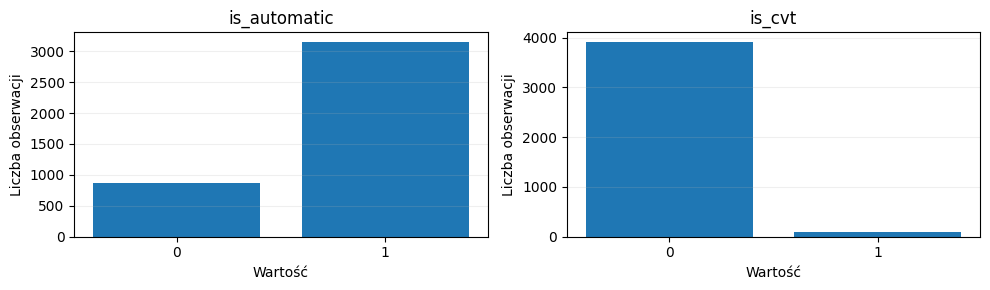

In [10]:
bin_cols = ['is_automatic', 'is_cvt']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for ax, col in zip(axes, bin_cols):
    counts = df_clean[col].value_counts(dropna=False).sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_xlabel('Wartość')
    ax.set_ylabel('Liczba obserwacji')
    ax.grid(True, axis='y', alpha=0.2)

plt.tight_layout()
plt.show()


Na histogramach widać kilka czytelnych rzeczy o rozkładach zmiennych i o tym, jak mogą się zachowywać w modelu.

Ceny (price) mają silnie prawostronnie skośny rozkład: większość aut jest w niższych przedziałach cenowych, a im droższe auta, tym szybciej maleje liczba obserwacji. Mimo przycięcia do 99 percentyla nadal widać „ogon”, co sugeruje obecność drogich, rzadkich ofert i potencjalnych obserwacji odstających. Z kolei log_price ma już rozkład dużo bardziej zbliżony do „dzwonowego”, więc logarytmowanie ceny wyraźnie stabilizuje zmienność i powinno ułatwić regresję (mniejszy wpływ skrajnych wartości).

Przebieg (milage) również jest mocno skośny: dominują auta z mniejszym przebiegiem, a im większy przebieg, tym mniej ogłoszeń. To jest zgodne z intuicją rynkową i zapowiada silną, ujemną zależność przebiegu od ceny. Rozkład rocznika (model_year) jest skoncentrowany na nowszych autach – widać dużo obserwacji z ostatnich kilkunastu lat, a starsze roczniki pojawiają się sporadycznie. To oznacza, że model będzie „najlepiej uczony” na rynku aut relatywnie nowych, a dla bardzo starych roczników danych jest mało.

Moc (hp) ma rozkład z wyraźnym skupieniem w okolicach typowych wartości dla aut osobowych (kilkaset koni mechanicznych) i długim ogonem w stronę bardzo dużych mocy – te najwyższe wartości to raczej auta sportowe/luksusowe i będą rzadkie. Pojemność (displacement_l) wygląda „schodkowo” – to naturalne, bo pojemności silników często występują w popularnych, powtarzalnych wariantach (np. okolice 2.0, 3.0, 3.5 itd.). Liczba biegów (n_speeds) ma kilka dominujących wartości (widać piki m.in. przy 6, 8, 10), co jest zgodne z typowymi konstrukcjami skrzyń biegów; jednocześnie widać, że to cecha nieciągła i w dodatku dostępna tylko dla części rekordów.

Na wykresach binarnych widać, że zdecydowana większość aut została oznaczona jako automaty (is_automatic = 1), natomiast skrzynie CVT (is_cvt = 1) stanowią mały odsetek zbioru. To sugeruje, że zmienna „automat/manual” może być użyteczna, ale CVT będzie cechą rzadką i jej wpływ może być trudniejszy do uchwycenia bez większej liczby przykładów.

Podsumowując: rozkłady price i milage są mocno skośne, więc w modelowaniu warto rozważyć pracę na log_price, a zmienne techniczne (hp, displacement_l, n_speeds) wyglądają realistycznie i mogą istotnie poprawić jakość predykcji.

## 6. Outliery cenowe

`price` ma rozkład silnie prawoskośny (pojedyncze bardzo drogie auta).


In [11]:
df_clean.nlargest(10, 'price')[['brand','model','model_year','milage','fuel_type','engine','transmission','accident','clean_title','price']]


,brand,model,model_year,milage,fuel_type,engine,transmission,accident,clean_title,price
693,Maserati,Quattroporte Base,2005,32000,Gasoline,394.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,At least 1 accident or damage reported,Yes,2954083
229,Bugatti,Veyron 16.4 Grand Sport,2011,6330,Gasoline,8.0L W16 64V GDI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,None reported,Yes,1950995
3046,Porsche,Carrera GT Base,2005,4400,Gasoline,605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,None reported,Yes,1599000
1356,Lamborghini,Aventador SVJ Base,2021,6987,Gasoline,6.5L V12 48V MPFI DOHC,7-Speed,None reported,Yes,749950
624,Rolls-Royce,Cullinan,2022,398,Gasoline,6.7L V12 48V GDI DOHC Twin Turbo,8-Speed Automatic,None reported,Yes,695000
979,Lamborghini,Aventador SVJ Base,2019,6929,Gasoline,759.0HP 6.5L 12 Cylinder Engine Gasoline Fuel,A/T,None reported,Yes,649999
1615,Rolls-Royce,Phantom,2023,1560,NaN,NaN,NaN,None reported,Yes,599995
1508,Rolls-Royce,Phantom,2018,7585,Gasoline,6.8L V12 48V GDI DOHC Twin Turbo,8-Speed Automatic,None reported,Yes,599000
3655,Lamborghini,Aventador S Base,2018,5858,Gasoline,729.0HP 6.5L 12 Cylinder Engine Gasoline Fuel,7-Speed A/T,None reported,Yes,491836
1061,Dodge,Viper GTC,2017,1389,Gasoline,645.0HP 8.4L 10 Cylinder Engine Gasoline Fuel,M/T,None reported,Yes,489995


W najwyższych cenach pojawiają się pojedyncze, bardzo drogie oferty (auta luksusowe/supersamochody typu Bugatti, Lamborghini, Rolls-Royce), które mocno „ciągną” rozkład ceny w prawo. Widać też jedną skrajną obserwację (~2.95 mln), która jest wyraźnie oderwana od reszty i może być albo realnym wyjątkiem, albo błędem w ogłoszeniu. Takie outliery będą silnie wpływać na średnią i na model regresji, dlatego w dalszej pracy warto rozważyć modelowanie log_price albo ograniczenie wpływu skrajnych wartości (np. przez przycięcie/winsoryzację lub osobną analizę segmentu premium).

In [12]:
q95 = df_clean['price'].quantile(0.95)
q99 = df_clean['price'].quantile(0.99)

out_stats = pd.DataFrame({
    'threshold': ['p95', 'p99'],
    'value': [q95, q99],
    'share_%': [
        (df_clean['price'] > q95).mean() * 100,
        (df_clean['price'] > q99).mean() * 100
    ]
})
out_stats


,threshold,value,share_%
0,p95,111600.00,5.013719
1,p99,272713.28,1.022699


Wyniki pokazują, że rozkład `price` ma bardzo długi prawy ogon: ok. **5%** obserwacji przekracza próg **p95 ≈ 111 600**, a ok. **1%** przekracza **p99 ≈ 272 713**. To oznacza, że w danych występują pojedyncze bardzo drogie auta, które silnie „ciągną” skalę cen i mogą dominować dopasowanie modelu w skali liniowej (np. zawyżać błędy i wpływać na współczynniki regresji).  

Dlatego uzasadnione jest użycie transformacji logarytmicznej ceny, np. `log_price = log(1 + price)`. Logarytm:
- **spłaszcza ogon** rozkładu i zmniejsza wpływ obserwacji odstających,
- często daje rozkład bliższy symetrycznemu, co sprzyja modelom liniowym,
- stabilizuje wariancję (różnice cen przy drogich autach nie „przeważają” nad różnicami przy tańszych),
- w praktyce sprawia, że model uczy się relacji bardziej w kategoriach **procentowych zmian** ceny niż absolutnych (np. „+10%”), co jest typowe dla danych ekonomicznych.

W dalszej części analiz i modelowania jako zmienną objaśnianą warto więc rozważać przede wszystkim `log_price`, a wynik końcowy można w razie potrzeby przeliczyć z powrotem na skalę ceny.


## 7. Sprawdzenie zależności między posiadanymi danymi

W tej części sprawdzamy, jak zmienne w zbiorze są ze sobą powiązane. Interesuje nas zarówno relacja cech z ceną (price), jak i relacje między cechami (np. czy dwie cechy niosą podobną informację). Dzięki temu łatwiej uzasadnić wybór zmiennych do modelu regresji i przewidzieć potencjalne problemy (np. współliniowość, małe grupy kategorii, wpływ braków danych).


In [13]:
# Wersje "filled" dla braków w kategoriach
df_clean['fuel_type_filled'] = df_clean['fuel_type'].fillna('Missing')
df_clean['accident_filled'] = df_clean['accident'].fillna('Missing')
df_clean['clean_title_filled'] = df_clean['clean_title'].fillna('Missing')

# Uproszczony typ skrzyni biegów (czytelniejszy do analiz zależności)
def simplify_transmission(s):
    s = '' if pd.isna(s) else str(s).strip()
    if s == '' or s == '–':
        return 'Unknown'
    if 'CVT' in s.upper():
        return 'CVT'
    if ('M/T' in s.upper()) or ('MANUAL' in s.upper()):
        return 'Manual'
    if ('A/T' in s.upper()) or ('AUTOMATIC' in s.upper()):
        return 'Automatic'
    if 'DUAL' in s.upper():
        return 'DualShift/DCT'
    return 'Other'

df_clean['trans_type'] = df_clean['transmission'].apply(simplify_transmission)

# Flaga braków clean_title (przydatna do analizy, czy "brak" coś znaczy)
df_clean['clean_title_missing'] = df_clean['clean_title'].isna().astype(int)

df_clean[['fuel_type_filled','accident_filled','clean_title_filled','trans_type']].nunique()


fuel_type_filled      7
accident_filled       3
clean_title_filled    2
trans_type            6
dtype: int64

## Zależności między zmiennymi liczbowymi

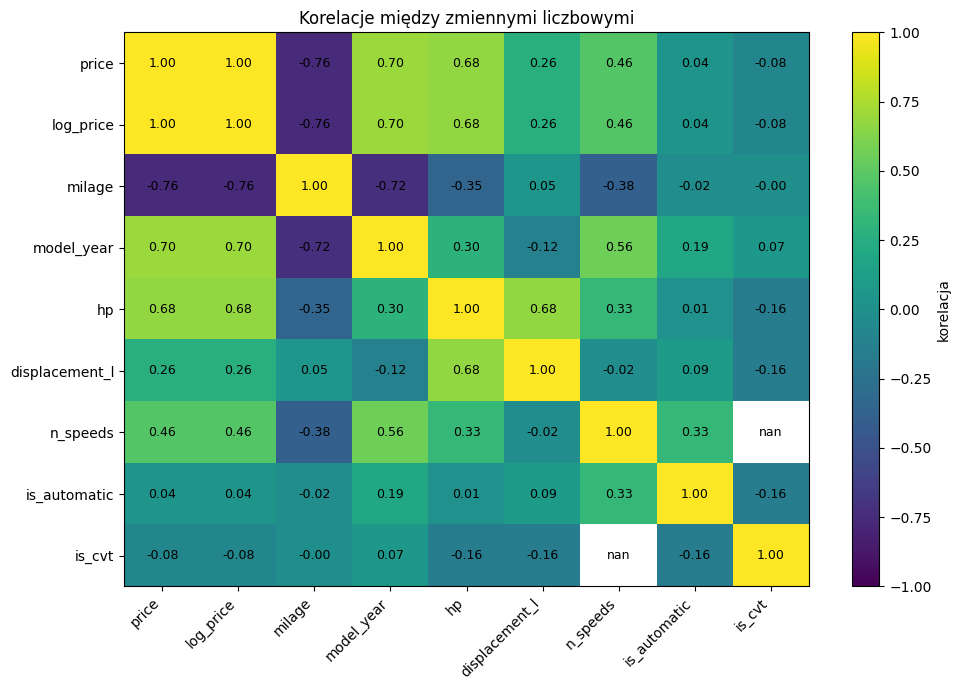

In [14]:
num_cols = ['price','log_price','milage','model_year','hp','displacement_l','n_speeds','is_automatic','is_cvt']
corr_s = df_clean[num_cols].corr(method='spearman')
corr_p = df_clean[num_cols].corr(method='pearson')

corr = corr_s  # albo corr_p

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(corr, aspect='auto', vmin=-1, vmax=1)

ax.set_xticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticks(range(len(num_cols)))
ax.set_yticklabels(num_cols)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('korelacja')

# wartości w komórkach
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        val = corr.iloc[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

ax.set_title('Korelacje między zmiennymi liczbowymi')
plt.tight_layout()
plt.show()



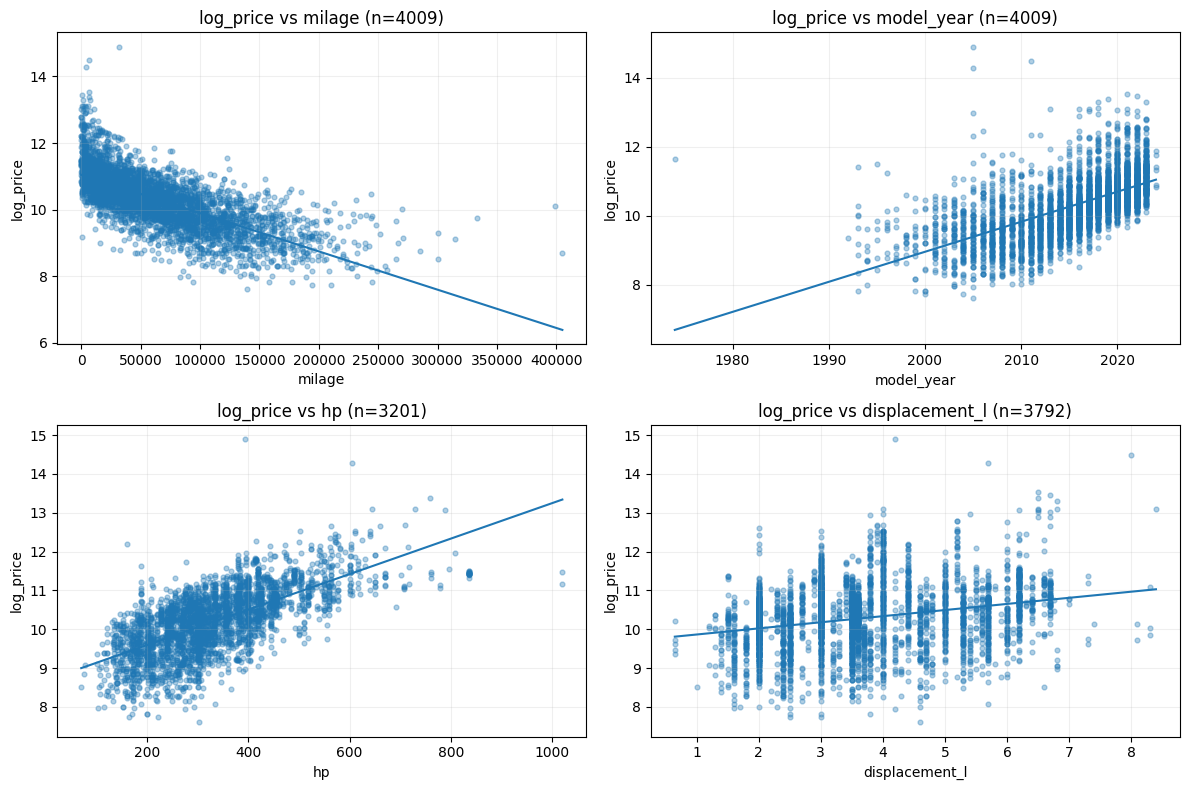

In [15]:
pairs = [
    ('milage', 'log_price'),
    ('model_year', 'log_price'),
    ('hp', 'log_price'),
    ('displacement_l', 'log_price')
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, (x, y) in zip(axes, pairs):
    tmp = df_clean[[x, y]].dropna()
    ax.scatter(tmp[x], tmp[y], alpha=0.35, s=12)
    
    # prosta linia trendu (polyfit) dla czytelności
    if len(tmp) > 5:
        m, b = np.polyfit(tmp[x], tmp[y], 1)
        xs = np.linspace(tmp[x].min(), tmp[x].max(), 100)
        ax.plot(xs, m*xs + b)

    ax.set_title(f'{y} vs {x} (n={len(tmp)})')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [16]:
features = ['milage','model_year','hp','displacement_l','n_speeds','is_automatic','is_cvt']

corr_summary = pd.DataFrame({
    'spearman(price)': df_clean[features + ['price']].corr('spearman')['price'].drop('price'),
    'pearson(log_price)': df_clean[features + ['log_price']].corr('pearson')['log_price'].drop('log_price'),
    'coverage_%': (df_clean[features].notna().mean() * 100).round(1)
}).sort_values('spearman(price)', key=lambda s: s.abs(), ascending=False)

corr_summary


,spearman(price),pearson(log_price),coverage_%
milage,-0.755174,-0.707793,100.0
model_year,0.697388,0.625211,100.0
hp,0.677765,0.669589,79.8
n_speeds,0.463063,0.336420,53.7
displacement_l,0.258598,0.262797,94.6
is_cvt,-0.080141,-0.066533,100.0
is_automatic,0.035861,0.021723,100.0


Na mapie korelacji widać przede wszystkim, że cena auta jest mocno powiązana z kilkoma „klasycznymi” czynnikami rynkowymi. Najsilniejsza zależność występuje między price (i praktycznie identycznie log_price) a przebiegiem milage – korelacja jest wyraźnie ujemna (ok. -0.76), co oznacza, że im większy przebieg, tym typowo niższa cena. Jednocześnie price jest silnie dodatnio skorelowana z model_year (ok. 0.70), czyli nowsze auta są statystycznie droższe. Widać też mocny dodatni związek ceny z mocą silnika hp (ok. 0.68), co sugeruje, że parametry osiągowe istotnie podbijają wartość ogłoszenia.

Mapa pokazuje również zależności między samymi cechami, które mogą oznaczać częściową redundancję informacji. model_year i milage mają silną ujemną korelację (ok. -0.72) – nowsze auta zwykle mają mniejszy przebieg, więc te dwie cechy częściowo opisują „wiek/zużycie” z dwóch stron. Moc hp jest mocno związana z pojemnością displacement_l (ok. 0.68), co jest logiczne technicznie i sugeruje, że te dwie zmienne mogą w modelu wnosić podobną informację (warto później sprawdzić, czy obie są potrzebne).

Liczba biegów n_speeds ma umiarkowane korelacje z ceną (ok. 0.46) i z rocznikiem (ok. 0.56), co może oznaczać, że nowsze auta częściej mają skrzynie o większej liczbie przełożeń, a to pośrednio wiąże się z wyższą ceną. Z kolei is_automatic ma bardzo słabą korelację z ceną (ok. 0.04), więc w tej prostej postaci „automat vs nie” raczej nie jest mocnym predyktorem, albo jego wpływ miesza się z innymi cechami (np. rocznik, segment auta). is_cvt ma niewielką ujemną korelację z ceną (ok. -0.08), ale jest to efekt mały i dodatkowo ta cecha jest rzadka w danych, więc nie należy jej przeceniać.

Na wykresie pojawia się NaN przy relacji n_speeds ↔ is_cvt, co najpewniej wynika z braków w n_speeds (dużo rekordów bez liczby biegów) i z małej liczby przypadków CVT – dla tej pary mogło zabraknąć wspólnych obserwacji do policzenia stabilnej korelacji.

## Zależność cech kategorycznych od ceny

W tej części sprawdzamy, czy i jak zmienne kategoryczne różnicują cenę auta. Ponieważ kategorie nie mają naturalnego porządku liczbowego, zamiast korelacji porównujemy rozkład cen w grupach (typowo: liczność count, mediana median, średnia mean). Mediana jest tu szczególnie ważna, bo jest odporna na obserwacje odstające (bardzo drogie auta).

In [17]:
cat_cols = ['brand', 'fuel_type', 'ext_col', 'int_col', 'accident', 'clean_title']

# Ujednolicenie braków: NaN oraz symbole typu '–' potraktujemy jako "Missing"
df_cat = df_clean.copy()

for c in cat_cols:
    df_cat[c] = df_cat[c].astype(str).str.strip()
    df_cat.loc[df_clean[c].isna(), c] = 'Missing'
    df_cat.loc[df_cat[c].isin(['', 'nan', 'NaN', 'None', '–']), c] = 'Missing'

# Kontrola: ile kategorii i czy są braki po ujednoliceniu
pd.DataFrame({
    'n_unique': [df_cat[c].nunique() for c in cat_cols],
    'missing_count': [(df_cat[c] == 'Missing').sum() for c in cat_cols]
}, index=cat_cols)


,n_unique,missing_count
brand,57,0
fuel_type,7,215
ext_col,319,15
int_col,156,133
accident,3,113
clean_title,2,596


In [18]:
def group_price_summary(data, col, target='price'):
    summary = (data
               .groupby(col)[target]
               .agg(count='count', median='median', mean='mean')
               .sort_values('count', ascending=False))
    return summary

summaries = {}
for c in cat_cols:
    summaries[c] = group_price_summary(df_cat, c)

# Wyświetl pełne tabele (dla brand/model/kolorów może być dużo wierszy)
for c in cat_cols:
    print(f"\n=== {c} ===")
    display(summaries[c].head(15))




=== brand ===


,count,median,mean
brand,,,
Ford,386,32377.5,36240.880829
BMW,375,32999.0,41072.309333
Mercedes-Benz,315,38598.0,52075.765079
Chevrolet,292,31992.5,36722.739726
Porsche,201,59900.0,88751.298507
Audi,200,34497.5,39907.430000
Toyota,199,27999.0,30026.000000
Lexus,163,30000.0,35668.521472
Jeep,143,30000.0,31099.790210



=== fuel_type ===


,count,median,mean
fuel_type,,,
Gasoline,3309,29950.0,44538.525839
Missing,215,44000.0,50506.069767
Hybrid,194,45499.0,51426.195876
E85 Flex Fuel,139,19500.0,22744.115108
Diesel,116,45450.0,48695.422414
Plug-In Hybrid,34,44945.0,45946.176471
not supported,2,14000.0,14000.000000



=== ext_col ===


,count,median,mean
ext_col,,,
Black,905,29950.0,40958.405525
White,816,30000.0,42604.754902
Gray,496,33100.0,45578.963710
Silver,374,22525.0,32440.245989
Blue,349,29000.0,38715.865330
Red,261,27000.0,50502.264368
Green,74,36750.0,45158.121622
Brown,43,21000.0,35220.860465
Gold,42,12500.0,17370.000000



=== int_col ===


,count,median,mean
int_col,,,
Black,2025,32999.0,43622.614815
Beige,538,19485.0,33215.395911
Gray,472,19447.5,27526.453390
Brown,157,37300.0,46390.509554
Missing,133,32500.0,54697.142857
White,127,44990.0,68062.708661
Red,126,39375.0,58598.055556
Jet Black,59,41986.0,47817.118644
Ebony,44,33292.5,43764.113636



=== accident ===


,count,median,mean
accident,,,
None reported,2910,35667.5,49638.073196
At least 1 accident or damage reported,986,20900.0,28831.500000
Missing,113,36500.0,50788.389381



=== clean_title ===


,count,median,mean
clean_title,,,
Yes,3413,29000.0,41734.390272
Missing,596,42996.5,60695.077181


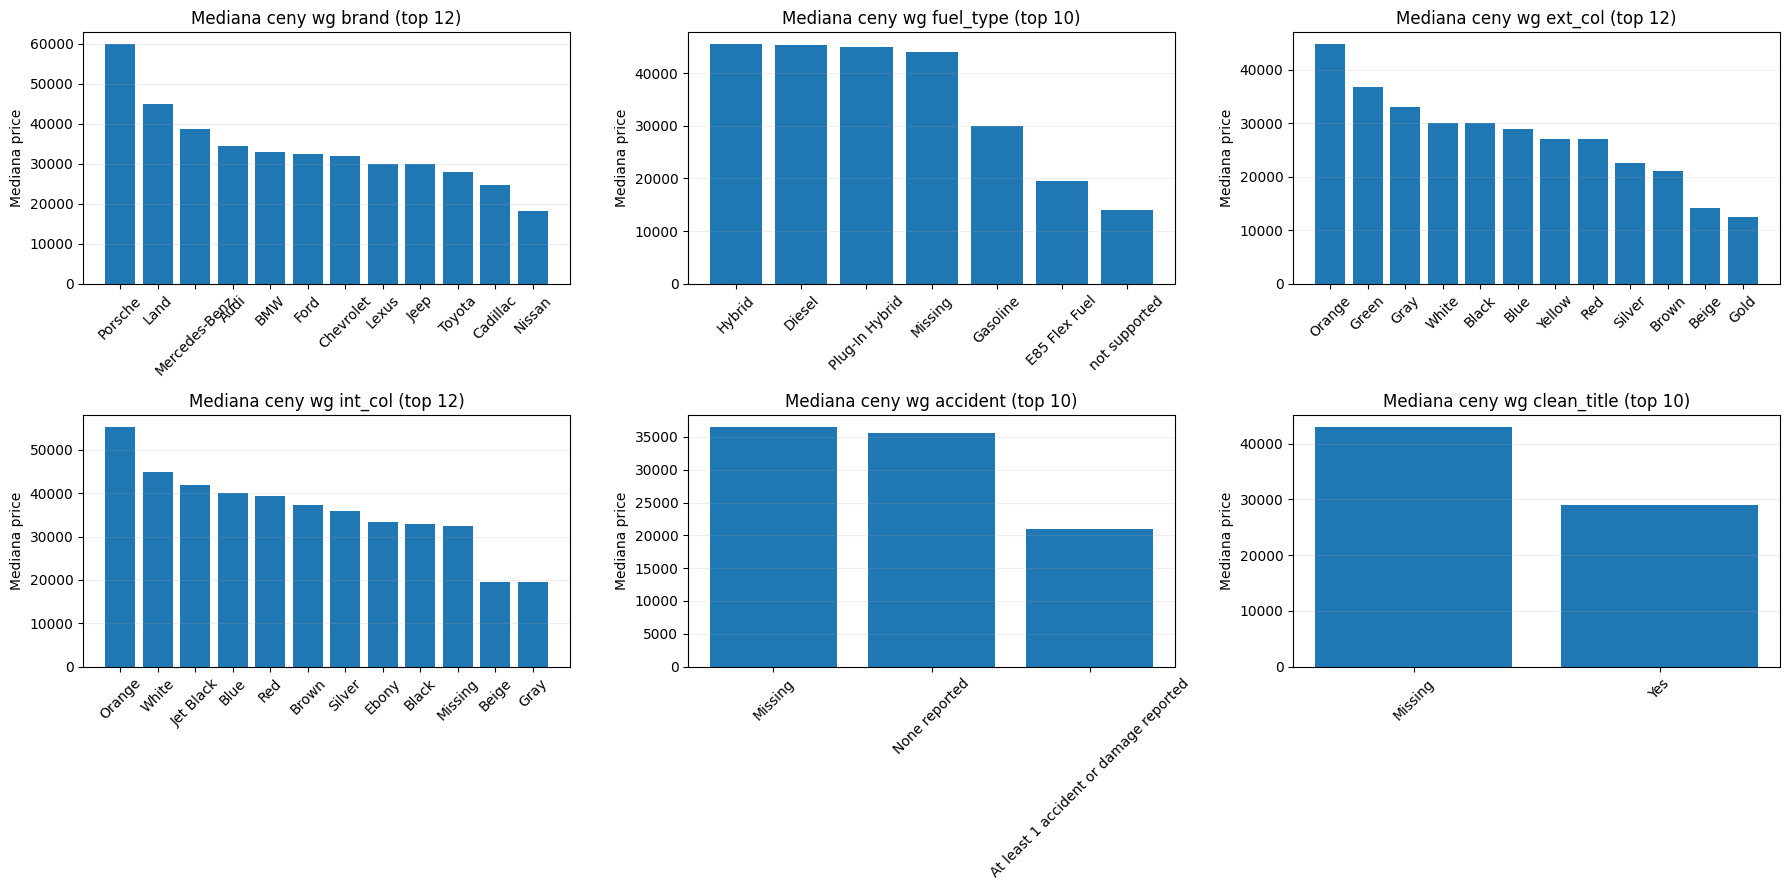

In [19]:
def top_categories(data, col, top_n=12):
    return data[col].value_counts().head(top_n).index

plot_cols = ['brand', 'fuel_type', 'ext_col', 'int_col', 'accident', 'clean_title']
top_n_map = {'brand': 12, 'ext_col': 12, 'int_col': 12, 'fuel_type': 10, 'accident': 10, 'clean_title': 10}

n_cols = 3
n_rows = (len(plot_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 9))
axes = axes.ravel()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    top = top_categories(df_cat, col, top_n=top_n_map[col])
    tmp = df_cat[df_cat[col].isin(top)]
    med = tmp.groupby(col)['price'].median().sort_values(ascending=False)

    ax.bar(med.index.astype(str), med.values)
    ax.set_title(f'Mediana ceny wg {col} (top {top_n_map[col]})')
    ax.set_ylabel('Mediana price')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.2)

# usuń puste osie
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_8720\2322663054.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=[str(b) for b in top_brand], vert=False)


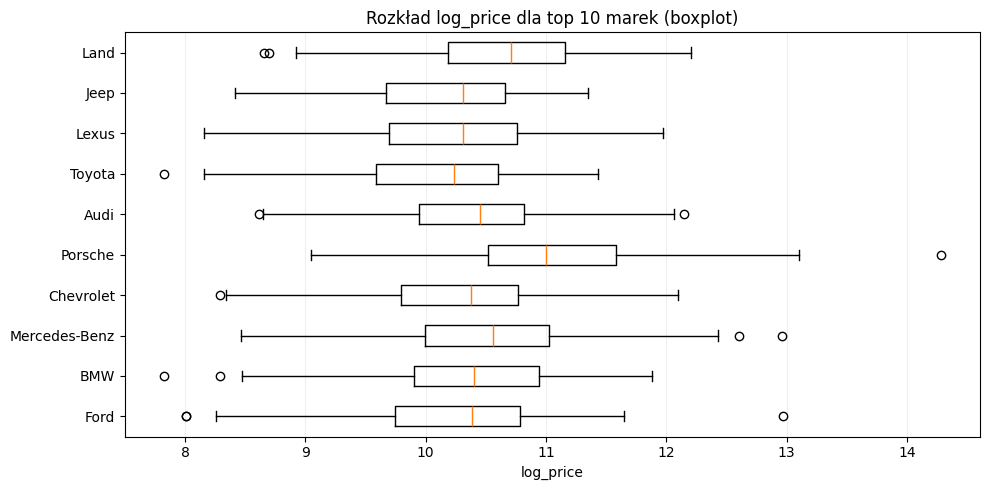

C:\Users\DELL\AppData\Local\Temp\ipykernel_8720\2322663054.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data2, labels=[str(c) for c in cats], vert=False)


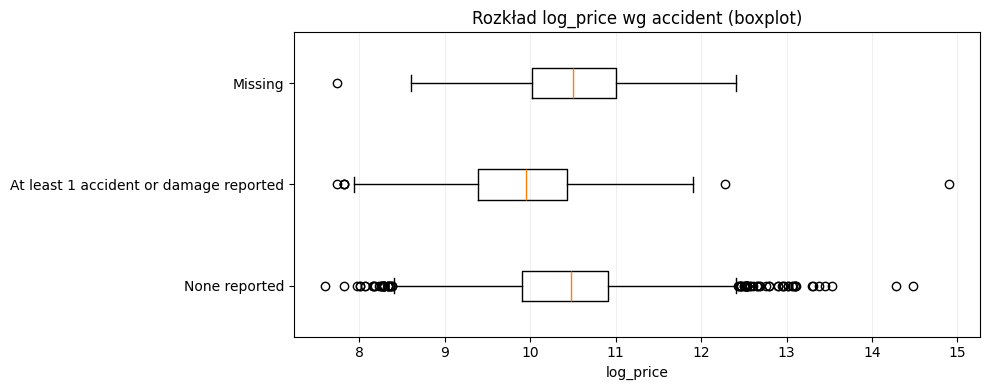

In [20]:
def topk(series, k=10):
    return series.value_counts().head(k).index

# brand - top 10
top_brand = topk(df_clean['brand'], 10)
tmp = df_clean[df_clean['brand'].isin(top_brand)].copy()

fig, ax = plt.subplots(figsize=(10, 5))
data = [tmp.loc[tmp['brand'] == b, 'log_price'].dropna() for b in top_brand]
ax.boxplot(data, labels=[str(b) for b in top_brand], vert=False)
ax.set_title('Rozkład log_price dla top 10 marek (boxplot)')
ax.set_xlabel('log_price')
ax.grid(True, axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

# fuel_type - wszystkie (albo top jeśli chcesz)
tmp2 = df_clean.copy()
tmp2['accident'] = tmp2['accident'].fillna('Missing')
cats = tmp2['accident'].value_counts().index.tolist()

fig, ax = plt.subplots(figsize=(10, 4))
data2 = [tmp2.loc[tmp2['accident'] == c, 'log_price'].dropna() for c in cats]
ax.boxplot(data2, labels=[str(c) for c in cats], vert=False)
ax.set_title('Rozkład log_price wg accident (boxplot)')
ax.set_xlabel('log_price')
ax.grid(True, axis='x', alpha=0.2)
plt.tight_layout()
plt.show()


In [21]:
def stable_groups_summary(data, col, min_count=20):
    tmp = (data.groupby(col)['price']
           .agg(count='count', median='median', mean='mean')
           .query('count >= @min_count')
           .sort_values('median', ascending=False))
    return tmp

min_count = 20

for c in cat_cols:
    print(f"\n=== {c} (min_count={min_count}) ===")
    display(stable_groups_summary(df_cat, c, min_count=min_count).head(15))



=== brand (min_count=20) ===


,count,median,mean
brand,,,
Lamborghini,26,258000.0,291233.846154
Bentley,33,113990.0,137553.545455
Porsche,201,59900.0,88751.298507
Tesla,87,45999.0,48439.471264
Land,130,44924.0,55764.061538
RAM,91,43449.0,43029.164835
Genesis,20,43174.5,43279.900000
Maserati,34,39000.0,140582.529412
Mercedes-Benz,315,38598.0,52075.765079



=== fuel_type (min_count=20) ===


,count,median,mean
fuel_type,,,
Hybrid,194,45499.0,51426.195876
Diesel,116,45450.0,48695.422414
Plug-In Hybrid,34,44945.0,45946.176471
Missing,215,44000.0,50506.069767
Gasoline,3309,29950.0,44538.525839
E85 Flex Fuel,139,19500.0,22744.115108



=== ext_col (min_count=20) ===


,count,median,mean
ext_col,,,
Orange,36,44750.0,53426.527778
Green,74,36750.0,45158.121622
Gray,496,33100.0,45578.963710
White,816,30000.0,42604.754902
Black,905,29950.0,40958.405525
Blue,349,29000.0,38715.865330
Yellow,29,27000.0,54717.655172
Red,261,27000.0,50502.264368
Silver,374,22525.0,32440.245989



=== int_col (min_count=20) ===


,count,median,mean
int_col,,,
Orange,20,55250.0,62782.200000
White,127,44990.0,68062.708661
Jet Black,59,41986.0,47817.118644
Blue,29,39990.0,46128.655172
Red,126,39375.0,58598.055556
Brown,157,37300.0,46390.509554
Ebony,44,33292.5,43764.113636
Black,2025,32999.0,43622.614815
Missing,133,32500.0,54697.142857



=== accident (min_count=20) ===


,count,median,mean
accident,,,
Missing,113,36500.0,50788.389381
None reported,2910,35667.5,49638.073196
At least 1 accident or damage reported,986,20900.0,28831.500000



=== clean_title (min_count=20) ===


,count,median,mean
clean_title,,,
Missing,596,42996.5,60695.077181
Yes,3413,29000.0,41734.390272


In [22]:
def short_insights(data, col, min_count=20, top_k=3):
    tmp = stable_groups_summary(data, col, min_count=min_count)
    if tmp.empty:
        return f"Dla {col} brak grup o liczności >= {min_count}, więc trudno o stabilne wnioski."
    
    top = tmp.head(top_k)
    bottom = tmp.tail(top_k).sort_values('median')
    
    msg = []
    msg.append(f"W {col} (po odfiltrowaniu grup z count < {min_count}) najwyższe mediany cen mają: " +
               ", ".join([f"{idx} (~{row['median']:.0f}, n={int(row['count'])})" for idx, row in top.iterrows()]) + ".")
    msg.append(f"Najniższe mediany cen mają: " +
               ", ".join([f"{idx} (~{row['median']:.0f}, n={int(row['count'])})" for idx, row in bottom.iterrows()]) + ".")
    return " ".join(msg)

for c in cat_cols:
    print(short_insights(df_cat, c, min_count=20, top_k=3))
    print()


W brand (po odfiltrowaniu grup z count < 20) najwyższe mediany cen mają: Lamborghini (~258000, n=26), Bentley (~113990, n=33), Porsche (~59900, n=201). Najniższe mediany cen mają: Mitsubishi (~10250, n=20), Chrysler (~11859, n=28), MINI (~12500, n=33).

W fuel_type (po odfiltrowaniu grup z count < 20) najwyższe mediany cen mają: Hybrid (~45499, n=194), Diesel (~45450, n=116), Plug-In Hybrid (~44945, n=34). Najniższe mediany cen mają: E85 Flex Fuel (~19500, n=139), Gasoline (~29950, n=3309), Missing (~44000, n=215).

W ext_col (po odfiltrowaniu grup z count < 20) najwyższe mediany cen mają: Orange (~44750, n=36), Green (~36750, n=74), Gray (~33100, n=496). Najniższe mediany cen mają: Gold (~12500, n=42), Beige (~14075, n=38), Brown (~21000, n=43).

W int_col (po odfiltrowaniu grup z count < 20) najwyższe mediany cen mają: Orange (~55250, n=20), White (~44990, n=127), Jet Black (~41986, n=59). Najniższe mediany cen mają: Gray (~19448, n=472), Beige (~19485, n=538), Missing (~32500, n=133

In [23]:
from scipy.stats import chi2_contingency

cat_cols = ['brand', 'fuel_type', 'ext_col', 'int_col', 'accident', 'clean_title']

df_cat = df_clean.copy()

# 1) Ujednolicenie braków (NaN, pusty string, '–' → 'Missing')
for c in cat_cols:
    s = df_cat[c]
    df_cat[c] = s.astype(str).str.strip()
    df_cat.loc[s.isna(), c] = 'Missing'
    df_cat.loc[df_cat[c].isin(['', 'nan', 'NaN', 'None', '–']), c] = 'Missing'

# 2) Opcjonalnie: ogranicz liczbę kategorii w kolorach (żeby nie mieć setek kategorii)
#    (jeśli nie chcesz, ustaw top_n=None)
def limit_categories(series, top_n=25, other_label='Other'):
    if top_n is None:
        return series
    top = series.value_counts().head(top_n).index
    return series.where(series.isin(top), other_label)

top_n = 25  # np. 25 najczęstszych, reszta jako 'Other' (dla ext/int col ma to sens)
df_cat['ext_col'] = limit_categories(df_cat['ext_col'], top_n=top_n)
df_cat['int_col'] = limit_categories(df_cat['int_col'], top_n=top_n)

# 3) Cramér's V (wersja z korektą obciążenia)
def cramers_v(x, y):
    tab = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(tab, correction=False)
    n = tab.to_numpy().sum()
    if n == 0:
        return np.nan

    phi2 = chi2 / n
    r, k = tab.shape

    # bias correction (Bergsma/Wicher style)
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    return 0.0 if denom <= 0 else np.sqrt(phi2corr / denom)

# 4) Macierz V
V = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for a in cat_cols:
    for b in cat_cols:
        V.loc[a, b] = 1.0 if a == b else cramers_v(df_cat[a], df_cat[b])

V


,brand,fuel_type,ext_col,int_col,accident,clean_title
brand,1.000000,0.333527,0.139814,0.206797,0.110644,0.150401
fuel_type,0.333527,1.000000,0.032501,0.094600,0.074736,0.073515
ext_col,0.139814,0.032501,1.000000,0.200058,0.106806,0.603462
int_col,0.206797,0.094600,0.200058,1.000000,0.075504,0.440657
accident,0.110644,0.074736,0.106806,0.075504,1.000000,0.428136
clean_title,0.150401,0.073515,0.603462,0.440657,0.428136,1.000000


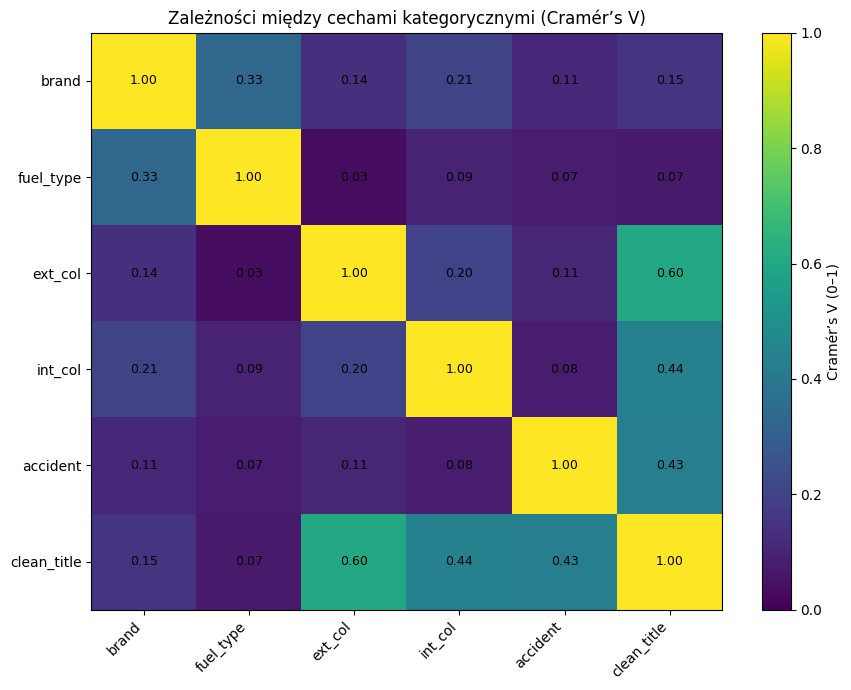

In [24]:
fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(V.values, vmin=0, vmax=1, aspect='auto')

ax.set_xticks(range(len(cat_cols)))
ax.set_yticks(range(len(cat_cols)))
ax.set_xticklabels(cat_cols, rotation=45, ha='right')
ax.set_yticklabels(cat_cols)

for i in range(len(cat_cols)):
    for j in range(len(cat_cols)):
        val = V.iloc[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Cramér’s V (0–1)")
ax.set_title("Zależności między cechami kategorycznymi (Cramér’s V)")
plt.tight_layout()
plt.show()


### Wnioski: zależności kategoryczne (Cramér’s V) i wpływ na cenę

Mapa Cramér’s V pokazuje, że większość cech kategorycznych jest względem siebie słabo lub umiarkowanie powiązana, ale są też pary o wyraźniejszych zależnościach. Najmocniej powiązane są kolory: `ext_col` z `int_col` (ok. 0.20) oraz `clean_title` z kolorami (szczególnie `clean_title` ↔ `ext_col` ok. 0.60 i `clean_title` ↔ `int_col` ok. 0.44). Oznacza to, że pewne kolory częściej występują w określonych typach ogłoszeń, a zmienna `clean_title` nie jest „losowa” względem wyglądu auta — może być pośrednio skorelowana z segmentem samochodu albo sposobem wystawiania oferty. Widać też umiarkowany związek `brand` ↔ `fuel_type` (ok. 0.33), co jest intuicyjne: różne marki mają różne „portfolio” napędów i częściej sprzedają określone typy paliwa. Z kolei `accident` ↔ `clean_title` ma wartość ok. 0.43, co sugeruje, że historia szkód i status tytułu mogą współwystępować (np. auta po zdarzeniach częściej mają specyficzny status dokumentów lub braki informacji).

Wykresy mediany ceny pokazują, że cechy kategoryczne realnie różnicują poziom ceny, ale część efektów może wynikać z tego, że dane kategorie są typowe dla aut z określonego segmentu. Dla `brand` w top 12 najwyższych median dominują marki z wyższej półki (np. Porsche, Land Rover, Mercedes-Benz), co potwierdza, że marka jest silnym nośnikiem informacji o segmencie i będzie ważnym predyktorem w regresji. Dla `fuel_type` najwyższe mediany mają hybrydy i diesel, a benzyna jest niżej — może to oznaczać realną premię cenową, ale warto pamiętać, że typ paliwa jest powiązany z rocznikiem i wyposażeniem, więc w modelu ten efekt może częściowo „przejść” na inne zmienne.

Kolory (`ext_col`, `int_col`) również pokazują różnice w medianach, ale te wyniki należy traktować ostrożnie: kolor często jest skorelowany z klasą auta oraz licznością danej kategorii, więc łatwo o efekt „rzadkości” (rzadkie kolory pojawiają się częściej w droższych, sportowych wersjach). W praktyce kolory mogą być przydatne, ale raczej jako cechy pomocnicze, a nie kluczowe determinanty ceny. Najbardziej jednoznaczny sygnał daje `accident`: auta z „None reported” są wyraźnie droższe niż te z „At least 1 accident or damage reported”, co jest zgodne z intuicją rynkową. Dodatkowo `clean_title` wypada nietypowo: kategoria `Missing` ma wyższą medianę ceny niż `Yes`, co pokazuje, że brak tej informacji nie powinien być automatycznie interpretowany jako „No”. To raczej sygnał, że braki w `clean_title` są systematyczne (zależą od typu ogłoszenia/segmentu), więc w dalszym przygotowaniu danych najlepiej potraktować `Missing` jako osobną kategorię lub dodać flagę braków.

Podsumowując, w zbiorze widać sensowne relacje między cechami kategorycznymi oraz ich wpływ na cenę. Do modelu regresyjnego szczególnie ważne będą: `brand`, `fuel_type`, `accident` i obsługa braków w `clean_title`. Kolory (`ext_col`, `int_col`) mogą poprawić dopasowanie, ale ich wpływ należy interpretować ostrożnie i najlepiej kontrolować go w obecności zmiennych liczbowych (rocznik, przebieg, parametry silnika).


## 8. Wnioski z eksploracji i propozycja (hipo)tezy badawczej

### Kluczowe obserwacje jakości danych
- W danych występują braki głównie w `clean_title` (~15%), a także w `fuel_type` i `accident` (kilka procent).
- W części rekordów brak informacji jest zakodowany jako znak `–` (zamieniony na `NaN`).
- `price` i `milage` wymagały czyszczenia i konwersji do typu liczbowego (symbole `$`, przecinki, jednostki).

### Rozkłady i outliery
- `price` ma silnie prawoskośny rozkład: większość aut jest w niższych widełkach, ale występują pojedyncze ekstremalnie drogie ogłoszenia.
-  W modelowaniu warto rozważyć: `log(price)` oraz metody odporne na outliery lub filtrowanie skrajnych obserwacji.

### Najważniejsze zależności
- `milage` ma silną **ujemną** zależność z ceną (na skali logarytmicznej jest to bardzo czytelne).
- `model_year` ma wyraźną **dodatnią** zależność z ceną.
- Wydobyta z opisu silnika moc `hp` jest również silnie powiązana z ceną (auta mocniejsze są zwykle droższe).
- `accident`: auta z raportowaną szkodą/wypadkiem mają niższą medianę ceny niż auta bez zgłoszonych zdarzeń.
- cechy kategoryczne takie jak `brand` czy `accident` wskazuja na korelacje z cena auta

### Teza / zadanie badawcze
**Zadanie:** opracować model regresji przewidujący `price` (lub `log(price)`) na podstawie cech pojazdu.
**Proponowany zestaw zmiennych objaśniających do modelu bazowego:**
- liczbowe: `model_year`, `milage`, `hp`, `displacement_l` (opcjonalnie `n_speeds`)
- kategoryczne: `brand`, `fuel_type`, `accident`, `clean_title` (z kategorią `Missing`/flagą braków)

**Zmienna objaśniana:** `log_price` (preferowana) oraz porównawczo `price`.


### Hipoteza badawcza
> *Cena używanego samochodu zależy w sposób istotny statystycznie od rocznika (`model_year`), przebiegu (`milage`) oraz parametrów opisujących osiągi (np. `hp`), a dodatkowo jest modyfikowana przez cechy kategoryczne takie jak marka (`brand`), typ paliwa (`fuel_type`), rodzaj skrzyni (`transmission`) oraz historia wypadków (`accident`).*


# Model regresyjny

## 0. Budowa potoku przetwarzania (Preprocessing Pipeline) i ramy testowe

Zanim przystąpimy do trenowania modeli, musimy przygotować infrastrukturę, która w sposób powtarzalny i bezpieczny (bez wycieku danych) przetworzy surowe informacje na format zrozumiały dla algorytmów. W tej sekcji definiujemy dwa główne elementy:
#### ColumnTransformer: 
Automatyczny system obróbki cech:
1. Dla cech numerycznych: Uzupełniamy braki medianą i dokonujemy standaryzacji (StandardScaler), aby cechy o dużych zakresach (np. przebieg) nie zdominowały tych o małych (np. pojemność silnika).
2. Dla cech kategorycznych: Braki oznaczamy jako "Missing", a następnie stosujemy kodowanie zero-jedynkowe (OneHotEncoder).
#### Uniwersalna funkcja testująca: 
Stworzona funkcja testująca wykorzystuje 5-krotną walidację krzyżową, co gwarantuje, że otrzymane wyniki są stabilne statystycznie i powtarzalne. Kluczowym elementem narzędzia jest automatyczne odwracanie logarytmów, dzięki czemu błędy MAE i RMSE możemy interpretować bezpośrednio w dolarach. Dodatkowo śledzimy błąd procentowy MAPE (najważniejsza metryka), który pozwala adekwatnie ocenić precyzję modelu zarówno dla tanich, jak i bardzo drogich samochodów. Cała architektura pozwala na błyskawiczne i rzetelne porównywanie różnych modeli oraz ich parametrów regularyzacji w identycznych, kontrolowanych warunkach.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Przygotowanie cech do użycia
numeric_features = ['model_year', 'milage', 'hp', 'displacement_l']
categorical_features = ['brand', 'fuel_type', 'accident', 'clean_title']

all_numeric_features = numeric_features
all_categorical_features = categorical_features + [ 'trans_type', 'ext_col', 'model', 'int_col', 'is_automatic', 'is_cvt', 'n_speeds']

# Wstępna obróbka danych, żeby nie było pustych wartości
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Funkcja do testowania modeli
def test_model(model_obj, alphas, X, y, preprocessor, is_log):
    for alpha in alphas:
        # Ustawienie parametru alpha
        model_obj.set_params(alpha=alpha)
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model_obj)
        ])

        # Predykcja modelu
        y_pred = cross_val_predict(pipeline, X, y, cv=5)
        
        if is_log:
            y_true_real = np.expm1(y)
            y_pred_real = np.expm1(y_pred)
            current_r2 = r2_score(y, y_pred)
        else:
            y_true_real = y
            y_pred_real = y_pred
            current_r2 = r2_score(y, y_pred)

        # Obliczanie metryk na wartościach rzeczywistych (dolary)
        mae = mean_absolute_error(y_true_real, y_pred_real)
        mse = mean_squared_error(y_true_real, y_pred_real)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true_real, y_pred_real) * 100
        
        print(f"Alpha: {alpha:<8} | R2: {current_r2:.4f} | MAE: {mae:>9.2f}$ | RMSE: {rmse:>9.2f}$ | MAPE: {mape:.2f}%")

## 1. Baseline: Regresja liniowa na surowych cenach (bez transformacji)
W tej sekcji ustanawiamy punkt odniesienia. 
Testujemy modele Ridge (regularyzacja L2) oraz Lasso (regularyzacja L1) na surowych wartościach kolumny price. Celem tego kroku jest sprawdzenie:
1. Czy modele liniowe potrafią poradzić sobie z dużą rozpiętością cen (od kilku tysięcy do milionów dolarów)?
2. Jak silny wpływ na stabilność modelu mają outliery (wartości odstające)?
3. Czy regularyzacja (parametr $\alpha$) jest w stanie zrekompensować nieliniowość rynku samochodowego?

In [26]:
X = df_clean[all_numeric_features + all_categorical_features]
y = df_clean['price']

print("Ridge:")
test_model(Ridge(), [0.001, 0.01, 0.1, 1, 1, 10, 100], X, y, preprocessor, 0)

print("LASSO:")
test_model(Lasso(max_iter=1000), [0.0001, 0.001, 0.01, 0.1], X, y, preprocessor, 0)

Ridge:
Alpha: 0.001    | R2: 0.2473 | MAE:  18169.18$ | RMSE:  68278.70$ | MAPE: 61.97%
Alpha: 0.01     | R2: 0.2473 | MAE:  18175.75$ | RMSE:  68278.77$ | MAPE: 62.01%
Alpha: 0.1      | R2: 0.2473 | MAE:  18237.21$ | RMSE:  68281.52$ | MAPE: 62.43%
Alpha: 1        | R2: 0.2463 | MAE:  18659.36$ | RMSE:  68326.35$ | MAPE: 65.31%
Alpha: 1        | R2: 0.2463 | MAE:  18659.36$ | RMSE:  68326.35$ | MAPE: 65.31%
Alpha: 10       | R2: 0.2294 | MAE:  19960.89$ | RMSE:  69088.02$ | MAPE: 72.45%
Alpha: 100      | R2: 0.1725 | MAE:  21770.64$ | RMSE:  71592.68$ | MAPE: 77.44%
LASSO:


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043074142283.7715, tolerance: 1011147965.3039045
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3165619152523.052, tolerance: 2195716126.922816
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWa

Alpha: 0.0001   | R2: 0.2458 | MAE:  18131.44$ | RMSE:  68347.01$ | MAPE: 61.53%


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043076997246.7986, tolerance: 1011147965.3039045
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3165626415247.8906, tolerance: 2195716126.922816
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceW

Alpha: 0.001    | R2: 0.2458 | MAE:  18131.45$ | RMSE:  68347.32$ | MAPE: 61.53%


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043105110631.7439, tolerance: 1011147965.3039045
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3165698794330.484, tolerance: 2195716126.922816
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWa

Alpha: 0.01     | R2: 0.2457 | MAE:  18131.56$ | RMSE:  68350.42$ | MAPE: 61.52%


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211348479613.86914, tolerance: 1011147965.3039045
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1688734192176.329, tolerance: 2195716126.922816
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWa

Alpha: 0.1      | R2: 0.2452 | MAE:  18132.03$ | RMSE:  68373.35$ | MAPE: 61.49%


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2882715459802.3926, tolerance: 2303608068.105872
  model = cd_fast.sparse_enet_coordinate_descent(


### Wyniki i wnioski
1. Niestabilność numeryczna (LASSO): Model Lasso przy surowych danych zgłasza błąd ConvergenceWarning. Wynika to z faktu, że przy cenach sięgających milionów dolarów, funkcja kosztu operuje na gigantycznych liczbach. Algorytm optymalizujący ma trudności ze znalezieniem minimum, co czyni model niewiarygodnym.
2. Wpływ outlierów na MAE: Średni błąd bezwzględny (MAE) jest drastycznie wysoki (ponad 13 000\$). Model jest ściągany przez najdroższe samochody , przez co jego wyceny dla segmentu aut popularnych stają się bardzo niedokładne (błedy ponad 60%).
3. Problem nieliniowości: Modele liniowe próbują dopasować prostą linię do danych, które mają charakter wykładniczy (auto traci na wartości najszybciej w pierwszych latach). Sama regularyzacja nie jest w stanie naprawić tego fundamentalnego niedopasowania strukturalnego.
4. Konieczność transformacji: Wyniki te jednoznacznie potwierdzają, że modelowanie surowej ceny prowadzi do błędów. Aby uzyskać stabilny model, konieczne jest zastosowanie transformacji logarytmicznej, która wyrówna wagę błędów dla tanich i drogich samochodów.

## 2. Regresja liniowa dla logarytmu ceny (po transformacji)
W tej sekcji wprowadzamy kluczową zmianę polegającą na predykcji logarytmu ceny zamiast jej surowej wartości, co ma na celu ustabilizowanie wariancji i spłaszczenie silnie prawostronnego rozkładu cen. Transformacja logarytmiczna sprawia, że różnice między bardzo drogimi a tanimi autami stają się dla modelu mniej ekstremalne, co zapobiega dominacji najdroższych rekordów nad procesem uczenia.

In [27]:
X = df_clean[all_numeric_features + all_categorical_features]
y_log = df_clean['log_price']

print("Ridge:")
test_model(Ridge(), [0.001, 0.01, 0.1, 1, 1, 10, 100], X, y_log, preprocessor, 1)

print("LASSO:")
test_model(Lasso(), [0.0001, 0.001, 0.01, 0.1], X, y_log, preprocessor, 1)

Ridge:
Alpha: 0.001    | R2: 0.8062 | MAE:  13176.40$ | RMSE:  66837.29$ | MAPE: 26.41%
Alpha: 0.01     | R2: 0.8062 | MAE:  13173.96$ | RMSE:  66836.19$ | MAPE: 26.40%
Alpha: 0.1      | R2: 0.8063 | MAE:  13167.87$ | RMSE:  66845.26$ | MAPE: 26.40%
Alpha: 1        | R2: 0.8060 | MAE:  13194.32$ | RMSE:  67019.87$ | MAPE: 26.39%
Alpha: 1        | R2: 0.8060 | MAE:  13194.32$ | RMSE:  67019.87$ | MAPE: 26.39%
Alpha: 10       | R2: 0.7964 | MAE:  13950.08$ | RMSE:  68828.88$ | MAPE: 26.87%
Alpha: 100      | R2: 0.7606 | MAE:  15480.08$ | RMSE:  71776.85$ | MAPE: 28.72%
LASSO:
Alpha: 0.0001   | R2: 0.8061 | MAE:  13174.25$ | RMSE:  66948.74$ | MAPE: 26.33%
Alpha: 0.001    | R2: 0.7975 | MAE:  13617.31$ | RMSE:  67932.10$ | MAPE: 26.68%
Alpha: 0.01     | R2: 0.7290 | MAE:  16461.97$ | RMSE:  72752.02$ | MAPE: 30.83%
Alpha: 0.1      | R2: 0.6707 | MAE:  17512.06$ | RMSE:  74475.38$ | MAPE: 35.01%


### Wyniki i wnioski

1. Redukcja wpływu wartości odstających (outlierów): Dzięki zastosowaniu transformacji logarytmicznej ekstremalnie wysokie ceny zostały „ściągnięte” w stronę centrum rozkładu, co zneutralizowało ich dominujący wpływ na proces uczenia. Metryka RMSE przestała być sztucznie zawyżana przez błędy w segmencie aut luksusowych, co bezpośrednio przełożyło się na drastyczny spadek błędu MAPE i lepszą generalizację modelu, co było kluczowym krokiem w optymalizacji modelu.
2. Znaczna poprawa stabilności: Zastosowanie logarytmu wyeliminowało błędy zbieżności w modelu LASSO, który teraz pracuje płynnie nawet przy niskich wartościach alfa.
3. Najlepszy wynik (MAPE): Najwyższą precyzję osiągnął model LASSO z parametrem $\alpha=0.0001$, uzyskując najniższy błąd procentowy wynoszący 26.33%.
4. Najlepsze dopasowanie (R2): Pod kątem współczynnika determinacji najlepiej wypadł Ridge z parametrem $\alpha=0.1$ ($R^2 = 0.8063$), co wskazuje na optymalny balans między dopasowaniem a regularyzacją.

## 3. Walidacja selekcji cech: Optymalizacja zestawu z EDA
W tej sekcji sprawdzamy, czy ograniczenie modelu do kluczowych cech wyselekcjonowanych podczas analizy eksploracyjnej (EDA) pozwoli na zachowanie wysokiej precyzji przy jednoczesnym uproszczeniu struktury algorytmu. Zamiast używać w modelu wszystkich dostępnych kolumn (które mogą wprowadzać szum informacyjny), skupiamy się na parametrach o udowodnionym znaczeniu rynkowym, takich jak rok produkcji, przebieg, moc silnika czy historia wypadkowości.

In [28]:
X = df_clean[numeric_features + categorical_features]
y_log = df_clean['log_price']

print("Ridge:")
test_model(Ridge(), [0.001, 0.01, 0.1, 1, 1, 10, 100], X, y_log, preprocessor, 1)

print("LASSO:")
test_model(Lasso(), [0.0001, 0.001, 0.01, 0.1], X, y_log, preprocessor, 1)

Ridge:
Alpha: 0.001    | R2: 0.8062 | MAE:  13176.40$ | RMSE:  66837.29$ | MAPE: 26.41%
Alpha: 0.01     | R2: 0.8062 | MAE:  13173.96$ | RMSE:  66836.19$ | MAPE: 26.40%
Alpha: 0.1      | R2: 0.8063 | MAE:  13167.87$ | RMSE:  66845.26$ | MAPE: 26.40%
Alpha: 1        | R2: 0.8060 | MAE:  13194.32$ | RMSE:  67019.87$ | MAPE: 26.39%
Alpha: 1        | R2: 0.8060 | MAE:  13194.32$ | RMSE:  67019.87$ | MAPE: 26.39%
Alpha: 10       | R2: 0.7964 | MAE:  13950.08$ | RMSE:  68828.88$ | MAPE: 26.87%
Alpha: 100      | R2: 0.7606 | MAE:  15480.08$ | RMSE:  71776.85$ | MAPE: 28.72%
LASSO:
Alpha: 0.0001   | R2: 0.8061 | MAE:  13174.25$ | RMSE:  66948.74$ | MAPE: 26.33%
Alpha: 0.001    | R2: 0.7975 | MAE:  13617.31$ | RMSE:  67932.10$ | MAPE: 26.68%
Alpha: 0.01     | R2: 0.7290 | MAE:  16461.97$ | RMSE:  72752.02$ | MAPE: 30.83%
Alpha: 0.1      | R2: 0.6707 | MAE:  17512.06$ | RMSE:  74475.38$ | MAPE: 35.01%


Wyniki pokazują, że usunięcie nadmiarowych cech i powrót do zestawu 8 zmiennych wyselekcjonowanych podczas EDA nie spowodowało pogorszenia jakości predykcji, a błąd MAPE utrzymał się na niemal identycznym poziomie 26.33%. Fakt ten jest bezpośrednim dowodem na to, że dodatkowe informacje, takie jak szczegółowe kolory czy typy skrzyń biegów, były dla modelu liniowego statystycznie redundantne i nie wnosiły nowej wartości informacyjnej. Aby ostatecznie potwierdzić tę decyzję, przechodzimy do analizy wag, która ujawnia, jak drastycznie marka dominuje nad pozostałymi parametrami oraz w jaki sposób specyficzne, rzadkie modele aut wprowadzały do algorytmu niepotrzebny szum, co objawiało się nienaturalnie wysokimi współczynnikami przy cechach o niskiej liczności.

In [29]:
X_eda = df_clean[numeric_features + categorical_features].copy()
X_all = df_clean[all_numeric_features + all_categorical_features].copy()
y = df_clean['log_price']

for col in all_numeric_features:
    if col in X_eda.columns:
        X_eda[col] = X_eda[col].fillna(X_eda[col].median())
    X_all[col] = X_all[col].fillna(X_all[col].median())

for col in all_categorical_features:
    if col in X_eda.columns:
        X_eda[col] = X_eda[col].fillna('missing').astype(str)
    X_all[col] = X_all[col].fillna('missing').astype(str)

scaler_eda = StandardScaler()
X_eda_num = scaler_eda.fit_transform(X_eda[numeric_features])
ohe_eda = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_eda_cat = ohe_eda.fit_transform(X_eda[categorical_features])
X_eda_final = np.hstack([X_eda_num, X_eda_cat])
names_eda = numeric_features + list(ohe_eda.get_feature_names_out(categorical_features))

scaler_all = StandardScaler()
X_all_num = scaler_all.fit_transform(X_all[all_numeric_features])
ohe_all = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_all_cat = ohe_all.fit_transform(X_all[all_categorical_features])
X_all_final = np.hstack([X_all_num, X_all_cat])
names_all = all_numeric_features + list(ohe_all.get_feature_names_out(all_categorical_features))

lasso_eda = Lasso(alpha=0.0001).fit(X_eda_final, y)
lasso_all = Lasso(alpha=0.0001).fit(X_all_final, y)

weights_eda = pd.Series(lasso_eda.coef_, index=names_eda)
weights_all = pd.Series(lasso_all.coef_, index=names_all)

print("EDA features")
print(weights_eda.abs().sort_values(ascending=False).head(30))

print("\nall features")
print(weights_all.abs().sort_values(ascending=False).head(30))

EDA features
brand_Bugatti              3.264698
brand_Rolls-Royce          1.480960
brand_Lamborghini          1.470468
brand_Ferrari              1.273697
brand_McLaren              1.209740
brand_Bentley              0.764820
fuel_type_not supported    0.731949
brand_Porsche              0.727064
brand_Lotus                0.679889
brand_Aston                0.659579
brand_Chrysler             0.486423
brand_Rivian               0.343010
brand_Hyundai              0.322488
milage                     0.321425
brand_Hummer               0.311349
fuel_type_Diesel           0.301753
model_year                 0.290860
brand_Maybach              0.265234
brand_Maserati             0.243164
brand_Plymouth             0.233791
brand_Mercedes-Benz        0.233508
brand_Land                 0.232075
brand_smart                0.202579
brand_Kia                  0.185486
hp                         0.180592
brand_Buick                0.175084
fuel_type_E85 Flex Fuel    0.168876
displacement_l 

### Wnioski z analizy wag
1. Zasada prostoty: Mimo że oba modele osiągają zbliżone metryki (MAPE ~26%), zestaw oparty na cechach z EDA jest obiektywnie lepszy. Uzyskanie niemal identycznego wyniku przy użyciu ułamka dostępnych cech świadczy o tym, że dodatkowe zmienne (jak kolory czy specyficzne nazwy modeli) są w dużej mierze redundantne. Prostszy model będzie znacznie stabilniejszy na nowych danych i mniej podatny na przeuczenie.
2. Absolutna dominacja marki: Wyniki czarno na białym pokazują, że marka jest najsilniejszym predyktorem ceny. W obu modelach brand_Bugatti posiada najwyższą wagę (powyżej 3.2), co oznacza gigantyczny skok ceny logarytmicznej w porównaniu do marek bazowych. Kolejne miejsca zajmują marki ultra-luksusowe: Rolls-Royce, Lamborghini i Ferrari (wagi 1.2 – 1.4). To potwierdza, że model w pierwszej kolejności próbuje „ustawić” auto na odpowiedniej półce cenowej poprzez logotyp na masce.
3. Rola fundamentów technicznych: Poza marką, kręgosłupem wyceny pozostają cechy numeryczne: przebieg (milage) i rok produkcji (model_year). Ich wysokie pozycje w rankingu (wagi ~0.3) potwierdzają, że po ustaleniu marki, to zużycie i wiek są kluczowe dla określenia wartości. Moc (hp) i Pojemność (displacement_l): Choć istotne, mają mniejszy wpływ niż prestiż marki, co jest logiczne – 500 KM w Fordzie nie kosztuje tyle samo, co 500 KM w Ferrari.

#### Wniosek końcowy: 
Pełny model próbuje uczyć się rynku „na pamięć”, wyłapując specyficzne modele aut, podczas gdy model EDA uczy się ogólnych reguł. Ponieważ naszym celem jest stworzenie stabilnego narzędzia do wyceny, zostajemy przy zestawie cech z EDA. Kolejnym krokiem, który pozwoli realnie obniżyć MAPE, nie będzie dodawanie kolejnych cech, lecz podział zbioru na segmenty (Premium vs Regular), aby model nie musiał „szukać kompromisu” między ceną Bugatti a Kii.

## 4. Podział modelu na Premium i Regular
Dotychczasowy model osiągnął limit błędu na poziomie 26% MAPE, co wynika z próby pogodzenia skrajnie różnych charakterystyk cenowych aut luksusowych i budżetowych. Ponieważ luksusowe marki tracą na wartości według zupełnie innych reguł niż auta masowe, w tym kroku dzielimy zbiór na dwa niezależne segmenty: Premium oraz Regular. Hipoteza zakłada, że trenując dwa wyspecjalizowane modele, zwiększymy jednorodność danych i precyzję wag, co pozwoli przełamać dotychczasowy „szklany sufit” predykcji.

In [30]:
brand_stats = df_clean.groupby('brand')['price'].median().sort_values(ascending=False)
threshold = brand_stats.quantile(0.8)
premium_brands = brand_stats[brand_stats >= threshold].index.tolist()
print(f"Marki zakwalifikowane jako Premium ({len(premium_brands)}):")
print(premium_brands)

df_premium = df_clean[df_clean['brand'].isin(premium_brands)].copy()
df_regular = df_clean[~df_clean['brand'].isin(premium_brands)].copy()

Marki zakwalifikowane jako Premium (12):
['Bugatti', 'Rolls-Royce', 'Lamborghini', 'Ferrari', 'McLaren', 'Bentley', 'Lucid', 'Rivian', 'Aston', 'Maybach', 'Porsche', 'Karma']


Wybór progu na poziomie 80. percentyla mediany cen dla poszczególnych marek został podyktowany wynikami eksperymentalnymi, które potwierdziły, że właśnie taka proporcja zapewnia najlepsze parametry modelu. Zakwalifikowanie 20% najdroższych marek do segmentu Premium pozwoliło na najskuteczniejsze odseparowanie pojazdów luksusowych od masowych, co zniwelowało negatywny wpływ ekstremalnych wartości na proces uczenia i przełożyło się na wyraźną poprawę metryk w obu nowo powstałych zbiorach.

In [31]:
X_premium = df_premium[numeric_features + categorical_features]
y_premium = df_premium['log_price']

print("Samochody premium")
print("Ridge:")
test_model(Ridge(), [0.001, 0.01, 0.1, 1, 1, 10, 100], X_premium, y_premium, preprocessor, 1)

print("LASSO:")
test_model(Lasso(max_iter=1000), [0.0001, 0.001, 0.01, 0.1], X_premium, y_premium, preprocessor, 1)

X_regular = df_regular[numeric_features + categorical_features]
y_regular = df_regular['log_price']

print("\nSamochody zwykłe")
print("Ridge:")
test_model(Ridge(), [0.001, 0.01, 0.1, 1, 1, 10, 100], X_regular, y_regular, preprocessor, 1)

print("LASSO:")
test_model(Lasso(max_iter=1000), [0.0001, 0.001, 0.01, 0.1], X_regular, y_regular, preprocessor, 1)

Samochody premium
Ridge:
Alpha: 0.001    | R2: 0.7286 | MAE:  47739.65$ | RMSE: 145617.53$ | MAPE: 33.25%
Alpha: 0.01     | R2: 0.7287 | MAE:  47715.50$ | RMSE: 145585.38$ | MAPE: 33.24%
Alpha: 0.1      | R2: 0.7300 | MAE:  47496.55$ | RMSE: 145293.23$ | MAPE: 33.13%
Alpha: 1        | R2: 0.7333 | MAE:  46601.46$ | RMSE: 143725.44$ | MAPE: 32.79%
Alpha: 1        | R2: 0.7333 | MAE:  46601.46$ | RMSE: 143725.44$ | MAPE: 32.79%
Alpha: 10       | R2: 0.7247 | MAE:  47388.86$ | RMSE: 142349.49$ | MAPE: 34.24%
Alpha: 100      | R2: 0.6644 | MAE:  58268.64$ | RMSE: 152687.29$ | MAPE: 41.32%
LASSO:
Alpha: 0.0001   | R2: 0.7314 | MAE:  47523.84$ | RMSE: 145406.13$ | MAPE: 32.93%
Alpha: 0.001    | R2: 0.7324 | MAE:  47032.38$ | RMSE: 144934.23$ | MAPE: 32.74%
Alpha: 0.01     | R2: 0.7137 | MAE:  49158.68$ | RMSE: 143663.42$ | MAPE: 35.63%
Alpha: 0.1      | R2: 0.6418 | MAE:  60898.13$ | RMSE: 152069.35$ | MAPE: 43.88%

Samochody zwykłe
Ridge:
Alpha: 0.001    | R2: 0.7866 | MAE:   9707.04$ | RMS

Analiza wyników po rozdzieleniu zbioru na dwa segmenty potwierdza, że auta luksusowe rządzą się zupełnie innymi prawami rynkowymi niż pojazdy masowe. Choć dla segmentu Premium błąd MAPE jest relatywnie wysoki i oscyluje wokół 32-33%, co wynika z ogromnej unikalności i spekulacyjnego charakteru cen najdroższych samochodów, to kluczowym osiągnięciem jest wyraźna poprawa precyzji w segmencie Regular. Spadek błędu do poziomu ok. 25% w tej grupie ma decydujące znaczenie dla całego projektu, ponieważ to właśnie samochody popularne stanowią dominującą większość zbioru danych.

In [32]:
from sklearn.model_selection import cross_val_predict

# 1. Wybieramy najlepsze modele (podstaw tutaj alphy, które u Ciebie wyszły najlepiej)
best_ridge_prem = Lasso(alpha=0.001)
best_ridge_reg = Ridge(alpha=10)

# 2. Generujemy predykcje dla obu grup osobno
y_pred_prem_log = cross_val_predict(Pipeline([('pre', preprocessor), ('reg', best_ridge_prem)]), X_premium, y_premium, cv=5)
y_pred_reg_log = cross_val_predict(Pipeline([('pre', preprocessor), ('reg', best_ridge_reg)]), X_regular, y_regular, cv=5)

# 3. Łączymy wyniki w jedną całość
y_true_combined_log = pd.concat([y_premium, y_regular])
y_pred_combined_log = np.concatenate([y_pred_prem_log, y_pred_reg_log])

# 4. Przeliczamy na dolary do metryk końcowych
y_true_final_usd = np.expm1(y_true_combined_log)
y_pred_final_usd = np.expm1(y_pred_combined_log)

# 5. Obliczamy metryki dla całego zbioru
total_r2 = r2_score(y_true_combined_log, y_pred_combined_log)
total_mae = mean_absolute_error(y_true_final_usd, y_pred_final_usd)
total_rmse = np.sqrt(mean_squared_error(y_true_final_usd, y_pred_final_usd))
total_mape = mean_absolute_percentage_error(y_true_final_usd, y_pred_final_usd) * 100

print(f"R2 (log-scale): {total_r2:.4f}")
print(f"MAE:            {total_mae:.2f}$")
print(f"RMSE:           {total_rmse:.2f}$")
print(f"MAPE:           {total_mape:.2f}%")

R2 (log-scale): 0.8122
MAE:            12668.47$
RMSE:           65197.14$
MAPE:           25.87%


### Wnioski:
1. Realny zysk z segmentacji: Połączenie predykcji z dwóch osobnych modeli pozwoliło na obniżenie globalnego błędu MAPE do poziomu 25.87% (w porównaniu do ok. 26.33% w najlepszym modelu globalnym). Choć spadek może wydawać się niewielki, w skali tysięcy wycen oznacza on znacznie większą precyzję i stabilność systemu, zwłaszcza w segmencie aut popularnych.
2. Synergia dwóch światów: Dzięki rozdzieleniu danych, model dla aut „Regular” nie był już zakłócany przez ekstremalne marże marek luksusowych, a model „Premium” mógł swobodniej dopasować wysokie wagi do prestiżowych marek. Końcowy współczynnik $R^2 = 0.8122$ potwierdza, że połączone podejście wyjaśnia ponad 81% zmienności cen w skali logarytmicznej.
3. Sufit regresji liniowej: Uzyskany wynik 25.87% jest prawdopodobnie najlepszym, co możemy wycisnąć z klasycznej regresji liniowej (Ridge/Lasso) przy obecnym inżynieringu cech. Aby zejść poniżej 20% MAPE, konieczne jest przejście do modeli nieliniowych, które potrafią wyłapać skomplikowane interakcje między wiekiem, mocą a prestiżem marki bez konieczności ręcznego definiowania segmentów.

## 5. Przełamanie barier: Model nieliniowy (HistGradientBoosting)
W ostatnim kroku naszego projektu przechodzimy do wykorzystania algorytmów nieliniowych, a konkretnie HistGradientBoostingRegressor. Modele liniowe, takie jak Ridge czy Lasso, mimo segmentacji rynku, nie były w stanie w pełni uchwycić złożonych, nieliniowych zależności między cechami. Model boostingowy buduje sekwencję drzew decyzyjnych, z których każde kolejne naprawia błędy swoich poprzedników, co pozwala na znacznie głębsze „zrozumienie” danych. Oczywiście użyjemy wszystkich znalezionych już wcześniej usprawnień modelu.

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

# --- 1. Definicja modelu ---
boosting_model = HistGradientBoostingRegressor(
    max_iter=100, learning_rate=0.1, max_depth=5, random_state=42
)

# --- 2. Predykcje dla modelu "SOLO" ---
pipe_solo = Pipeline(steps=[('pre', preprocessor), ('reg', boosting_model)])
y_pred_solo_log = cross_val_predict(pipe_solo, X, y_log, cv=5)

# --- 3. Predykcje dla modelu "HYBRYDA"
pipe_hyb = Pipeline(steps=[('pre', preprocessor), ('reg', boosting_model)])
y_pred_prem_log = cross_val_predict(pipe_hyb, X_premium, y_premium, cv=5)
y_pred_reg_log = cross_val_predict(pipe_hyb, X_regular, y_regular, cv=5)

# --- 4. Łączymy wyniki hybrydy ---
y_true_combined_log = pd.concat([y_premium, y_regular])
y_pred_combined_log = np.concatenate([y_pred_prem_log, y_pred_reg_log])

# --- 5. Konwersja na dolary ---
y_true_all_usd = np.expm1(y_log) 
y_pred_solo_usd = np.expm1(y_pred_solo_log)

y_true_hyb_usd = np.expm1(y_true_combined_log)
y_pred_hyb_usd = np.expm1(y_pred_combined_log)

# --- 6. Obliczanie metryk ---
def get_metrics(true_log, pred_log, true_usd, pred_usd):
    return {
        'R2': r2_score(true_log, pred_log),
        'MAE': mean_absolute_error(true_usd, pred_usd),
        'RMSE': np.sqrt(mean_squared_error(true_usd, pred_usd)),
        'MAPE': mean_absolute_percentage_error(true_usd, pred_usd) * 100
    }

m_solo = get_metrics(y_log, y_pred_solo_log, y_true_all_usd, y_pred_solo_usd)
m_hyb = get_metrics(y_true_combined_log, y_pred_combined_log, y_true_hyb_usd, y_pred_hyb_usd)

# --- 7. Wyświetlenie wyników ---
print(f"{'Metryka':<15} | {'Model SOLO':<15} | {'Hybryda':<18}")
print("-" * 55)
for k in m_solo.keys():
    print(f"{k:<15} | {m_solo[k]:>15.4f} | {m_hyb[k]:>15.4f}")

Metryka         | Model SOLO      | Hybryda           
-------------------------------------------------------
R2              |          0.8518 |          0.8614
MAE             |      11986.9264 |      10998.8441
RMSE            |      65132.1986 |      63514.5000
MAPE            |         23.3547 |         22.1433


### Wnioski
1. Przełamanie bariery regresji liniowej: Przejście na model nieliniowy znacząco poprawiło wyniki regresji. Najlepszy model liniowy (Hybryda Lasso/Ridge) osiągał 25.87% MAPE. Boosting już na starcie poprawił ten wynik o blisko 2.5 punktu procentowego, a w wersji hybrydowej zredukował błąd do 22.14%. To dowodzi, że nieliniowe zależności są kluczowe w wycenie pojazdów.
2. Segmentacja wciąż ma znaczenie: Nawet tak zaawansowany model jak HistGradientBoosting zyskuje na fizycznym rozdzieleniu danych na segmenty Premium i Regular. Poprawa MAE o prawie 1000 $ pokazuje, że podział modelu na konkretne grupy cenowe pomaga mu lepiej zrozumieć specyfikę rynku samochodowego.
3. Wyjaśnienie zmienności: Wynik R2 = 0.8614 oznacza, że nasz finalny model wyjaśnia ponad 86% zmienności cen (w skali logarytmicznej). Jest to wynik bardzo wysoki, biorąc pod uwagę, że nie dysponujemy danymi o stanie technicznym konkretnych egzemplarzy (np. czy auto było bite, jak wygląda wnętrze).

## Podsumowanie
1. Weryfikacja tezy: Przeprowadzone badanie w pełni potwierdziło tezę, że cena pojazdu zależy w sposób istotny statystycznie od rocznika, przebiegu i mocy (parametry numeryczne) oraz marki i historii pojazdu (parametry kategoryczne). Analiza istotności cech wykazała, że to właśnie te fundamenty stanowią kręgosłup wyceny, przy czym marka (brand) jest najsilniejszym modyfikatorem, potrafiącym zmienić wartość auta o rzędy wielkości.
2. Optymalizacja zestawu cech: Udowodniliśmy, że prostszy model oparty na 8 cechach z EDA jest równie skuteczny (a przy tym stabilniejszy) co model operujący na 25 cechach. Pozwoliło to na wyeliminowanie szumu informacyjnego (np. koloru lakieru), który dla modeli liniowych był statystycznie nieistotny.
3. Przewaga nieliniowości: Modele liniowe (Ridge, Lasso), mimo zastosowania segmentacji, osiągnęły „szklany sufit” na poziomie 25.87% MAPE. Dopiero wdrożenie algorytmu HistGradientBoosting pozwoliło na uwzględnienie skomplikowanych zależności między cechami, co skutkowało gwałtownym wzrostem precyzji.
4. Skuteczność strategii hybrydowej: Najlepsze wyniki w całym projekcie przyniosła Hybryda nieliniowa (osobne modele boostingowe dla segmentów Premium i Regular). Podejście to pozwoliło osiągnąć błąd MAPE na poziomie 22.14% oraz współczynnik $R^2 = 0.86$, co oznacza, że nasz model wyjaśnia 86% zmienności cen w skali logarytmicznej.
### Wniosek końcowy
Finalna strategia hybrydowa udowodniła, że połączenie zaawansowanych algorytmów nieliniowych z ekspercką segmentacją rynku jest najskuteczniejszą drogą do precyzyjnej wyceny pojazdów, pozwalającą na skuteczne odseparowanie aut masowych od specyficznego i zmiennego rynku aut luksusowych.